<a href="https://colab.research.google.com/github/LarsAmker/ExplainGAN/blob/master/Pneumonia_compact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and access the data

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
#!pwd
!mkdir ~/.kaggle
#!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

The kaggle.json file is needed to get the data directly from kaggle. Copy it over from my google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# copy the json file from google drive into the kaggle directory
!cp "/content/gdrive/My Drive/kaggle.json" ~/.kaggle

In [5]:
# Download pneumonia data (first line makes kaggle API key unreadable)
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# the zip file is listed in the left hand pane after the download. We need to unzip and create paths

100% 2.29G/2.29G [00:30<00:00, 13.5MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.5MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip

In [7]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

# added tensorflow and stuff from the MNIST classifier:
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
import PIL
import time
from IPython import display

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# My directory is called "content" instead of "input" as in the original code
#os.listdir("../content/chest_xray/chest_xray") 

NAIN had a code box fixing some random seeds here. Not compatible with tf2 however, therefore deleted and saved in testPneumonia/reproducability

In [8]:
# Clone the github repo to get access to the outsourced building blocks
!git clone https://github.com/LarsAmker/ExplainGAN

Cloning into 'ExplainGAN'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 489 (delta 55), reused 0 (delta 0), pack-reused 378
Receiving objects: 100% (489/489), 2.08 MiB | 4.62 MiB/s, done.
Resolving deltas: 100% (273/273), done.


## Make the data accessible

The dataset is divided into three sets: 1) train set 2) validation set and 3) test set. Let's grab the dataset

Each of the above directories contains two sub-directories:

NORMAL: These are the samples that describe the normal (no pneumonia) case.

PNEUMONIA: This directory contains those samples that are the pneumonia cases.

In [0]:
%run ExplainGAN/blocksPneumonia/data

In NAIN's classifier, the training data is handled differently: He just created a dataframe of paths to the images and the labels in a second column. Then he used a data generator for the training. Using the generator in the training of my multi-network ExplainGAN model did not work (or at least I did not figure out how to make it work), so I transfered the data import steps of validation and test data and I do the batching in the way of my MNIST code later on, before the training.

# Classifier (NAIN's depthwise kernel)

Build and compile an empty model and then load the weights for it from my google drive. These weights were created and saved in the notebook "PneumoniaClassifier.ipynb"

In [0]:
# changed the format of this method due to compatibility with tensorflow 2
# The original version from NAIN worked with "x=...(x)" steps, my theory is that this x is the placeholder that lead to errors
from tensorflow.keras import layers

def build_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1_1', input_shape=[224, 224, 3]))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1_2', input_shape=[224, 224, 3]))
  model.add(layers.MaxPooling2D((2,2), name='pool'))

  model.add(layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1'))
  model.add(layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2'))
  model.add(layers.MaxPooling2D((2,2), name='pool2'))

  model.add(layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1'))
  model.add(layers.BatchNormalization(name='bn1'))
  model.add(layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2'))
  model.add(layers.BatchNormalization(name='bn2'))
  model.add(layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3'))
  model.add(layers.MaxPooling2D((2,2), name='pool3'))

  model.add(layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1'))
  model.add(layers.BatchNormalization(name='bn3'))
  model.add(layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2'))
  model.add(layers.BatchNormalization(name='bn4'))
  model.add(layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3'))
  model.add(layers.MaxPooling2D((2,2), name='pool4'))

  model.add(layers.Flatten(name='flatten'))
  model.add(layers.Dense(1024, activation='relu', name='fc1'))
  model.add(layers.Dropout(0.7, name='dropout1'))
  model.add(layers.Dense(512, activation='relu', name='fc2'))
  model.add(layers.Dropout(0.5, name='dropout2'))
  model.add(layers.Dense(2, activation='softmax', name='fc3'))
  
  return model

In [0]:
classifier =  build_model()
#model.summary()

In [0]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
classifier.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [16]:
classifier.load_weights('/content/gdrive/My Drive/Colab Notebooks/DepthwiseWeights')

### Testing classifier

In [17]:
# Evaluation on test dataset
test_loss, test_score = classifier.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

39/39 [==============================] - 1s 34ms/step - loss: 1.4144 - accuracy: 0.7965
Loss on test set:  1.4144046306610107
Accuracy on test set:  0.7964743375778198


In [0]:
# Get predictions
preds = classifier.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

#print(orig_test_labels.shape)
#print(preds.shape)

In [0]:
# Get the confusion matrix
cm = confusion_matrix(orig_test_labels, preds)
plt.figure()
#plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, alpha=0.7,cmap=plt.cm.Blues)
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
#plt.show()

In [0]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
#print("Recall of the classifier is {:.2f}".format(recall))
#print("Precision of the classifier is {:.2f}".format(precision))

Running everything up to this point takes 3 and a half minutes.

# ExplainGAN

In [10]:
print(train_data.shape) # this is a data frame of paths to the images and their labels.
# The train data generator gets the images from the paths. This saves memory compared to saving all training images
print(valid_data.shape)
print(test_data.shape)

(5216, 224, 224, 3)
(16, 224, 224, 3)
(624, 224, 224, 3)


## Encoder

In [0]:
# Copied from https://blog.keras.io/building-autoencoders-in-keras.html, added flattening at the end
# Also changed the activation function from relu to sigmoid to not get exploding latent variables
# Maybe change this back if I train the encoder separately before training the rest of ExplainGAN. Then, also move the flattening

# Change input shape, but use only one of the three RGB channels
def make_encoder_model(activ_fct):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation=activ_fct, padding='same', use_bias=True,
                                     input_shape=[224, 224, 3]))
    model.add(layers.MaxPooling2D((2,2), padding='same'))

    model.add(layers.Conv2D(8, (3, 3), activation=activ_fct, padding='same', use_bias=True))
    model.add(layers.MaxPooling2D((2,2), padding='same'))

    model.add(layers.Conv2D(8, (3, 3), activation=activ_fct, padding='same', use_bias=True))
    model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Conv2D(8, (3, 3), activation=activ_fct, padding='same', use_bias=True))
    model.add(layers.MaxPooling2D((2,2), padding='same'))
    model.add(layers.Flatten())
    
    return model
# At this point the representation is (4, 4, 8) i.e. 128-dimensional
# The convolutions here don't decrease the 2D dimension because they have default (1,1) strides. The MaxPooling does

In [0]:
encoder0 = make_encoder_model(activ_fct='relu')
encoder1 = make_encoder_model(activ_fct='relu')
#encoder0.summary()

In [0]:
encoded = encoder0(test_data[0:1,:,:,:])

## Generators

The generator_start is the biggest part of ExplainGAN, i.e. the one with the most weights. I already ran into one OOM error with this version of the code after building ~5 models with 123 millions of weights. The vast majority of weights appears in the very first, dense, layer. 

Make this smaller somehow. Let's try to create fewer 7*7 images (in MNIST, we created 128 of these from an encoded vector of length 128). Try 128 for now. Then we have only 10 millions of weights in generator_start

In [0]:
# This generator is based on the DCGAN generator. But now, we need 3 outputs and not just one!
# Therefore tear it apart in the middle. We will use the second part three times to get recon and trafo and mask 
def make_generator_model_start():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(1568,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Create images of size 7*7 with 128 channels, all connected to the 128 nodes of the encoded original image
    # In the next 2 lines, the tensor is actually reshaped into that channel form

    model.add(layers.Reshape((7, 7, 128)))
    assert model.output_shape == (None, 7, 7, 128) # Note: None is the batch size

    # now move 5*5*128(channels) filters over the 7*7*128(channels) images in 1,1 strides. Do this for each of the 64 output channels.
    # 64 is the number of different filters we apply. Because of the big number of input channels, each filter is already huge
    # The number of parameters here is 5*5*128 (filter weights) *64 (number of filters)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    return model
    
 
# Now the second part. Apply this three times to get reconstruction and transformation and mask
# Because of the splitting, I also needed to add the input shape in the first layer of this second part.
def make_generator_model_end_sigmoid(): # second version to get a mask with values in [0,1] instead of [-1,1] with tanh
    # By taking strides of 2, the size of the image gets doubled in length and width.
    # This is the case, because we do a backwards convolution. If we get a 7*7 image by taking (2,2)-strides, we must have started with 14*14
    model = tf.keras.Sequential()
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=(7,7,64)))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=(14,14,32)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=(28,28,16)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=(56,56,8)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 224, 224, 1)
    return model

In [0]:
generator_start = make_generator_model_start()
#generator_start.summary()
reconstructor = make_generator_model_end_sigmoid()
#reconstructor.summary()

In [0]:
gen_started = generator_start(encoded)
#gen_started # shape (1,7,7,64)

In [0]:
reconstructed = reconstructor(gen_started)
#reconstructed # shape (1,224,224,1) like a grayscale x-ray scan

## Loss function and optimizers

In [0]:
# inputs of loss_recon are two images, the original one and its reconstruction 
def loss_recon(x, reconstruction):
  difference = tf.subtract(x,reconstruction)
  # reshape 224*224 to one vector in order to apply the l2 norm to it
  # The -1 in the first dimension make sure that the number of images stays the same, images shall not be combined
  difference = tf.reshape(difference, [-1,50176,1])
  return tf.math.square(tf.norm(difference, ord=2, axis=1))

In [0]:
# Testing
#loss_recon(valid_data[:,:,:,0], valid_data[:,:,:,0])

In [0]:
enc0_optimizer = tf.keras.optimizers.Adam(1e-4)
enc1_optimizer = tf.keras.optimizers.Adam(1e-4)
gen_start_optimizer = tf.keras.optimizers.Adam(1e-4)
recon_optimizer = tf.keras.optimizers.Adam(1e-4)

## Experimenation

In [0]:
images = valid_data
predicted_classes = classifier.predict(images) # model takes (224,224,3) as input
predicted_classes = np.argmax(predicted_classes, axis=1) # now we have the actual predictions
predicted_classes = tf.reshape(predicted_classes, [-1,1]) # make it compatible with tensors below
predicted_classes = tf.cast(predicted_classes, tf.float32) # change type to float for multiplications
predicted_classes

images_grayscale = images[:,:,:,0:1]
#images_grayscale.shape

In [33]:
with tf.GradientTape() as enc0_tape, tf.GradientTape() as enc1_tape, tf.GradientTape() as gen_start_tape, tf.GradientTape() as recon_tape:
  z_as0 = encoder0(images)
  z_as1 = encoder1(images)
  gen_from_pred0 = generator_start(z_as0)
  gen_from_pred1 = generator_start(z_as1)
  recon_from_pred0 = reconstructor(gen_from_pred0)
  recon_from_pred1 = reconstructor(gen_from_pred1)
  print("recon0 shape:", recon_from_pred0.shape)
  print("recon1 shape:", recon_from_pred1.shape)
  print("images_grayscale shape:", images_grayscale.shape)

  loss_recon0 = loss_recon(images_grayscale, recon_from_pred0)
  loss_recon1 = loss_recon(images_grayscale, recon_from_pred1)
  print("loss_recon0 shape:", loss_recon0.shape)
  loss_r0 = tf.math.multiply(1-predicted_classes, loss_recon0) # set the loss for the wrong recons to 0
  loss_r1 = tf.math.multiply(predicted_classes, loss_recon1) # set the loss for the wrong recons to 0
  loss_r = (loss_r0 + loss_r1)*0.0005
  loss_summed = loss_r
  print("loss_summed shape:", loss_summed.shape)

  gradients_of_enc0 = enc0_tape.gradient(loss_summed, encoder0.trainable_variables)
  gradients_of_enc1 = enc1_tape.gradient(loss_summed, encoder1.trainable_variables)
  gradients_of_gen_start = gen_start_tape.gradient(loss_summed, generator_start.trainable_variables)
  gradients_of_recon = recon_tape.gradient(loss_summed, reconstructor.trainable_variables)

  enc0_optimizer.apply_gradients(zip(gradients_of_enc0, encoder0.trainable_variables))
  enc1_optimizer.apply_gradients(zip(gradients_of_enc1, encoder1.trainable_variables))
  gen_start_optimizer.apply_gradients(zip(gradients_of_gen_start, generator_start.trainable_variables))
  recon_optimizer.apply_gradients(zip(gradients_of_recon, reconstructor.trainable_variables))

  print('loss_r: ', tf.reduce_max(loss_r), tf.reduce_min(loss_r), tf.reduce_mean(loss_r))

recon0 shape: (16, 224, 224, 1)
recon1 shape: (16, 224, 224, 1)
images_grayscale shape: (16, 224, 224, 1)
loss_recon0 shape: (16, 1)
loss_summed shape: (16, 1)
loss_r:  tf.Tensor(2.433419, shape=(), dtype=float32) tf.Tensor(1.208833, shape=(), dtype=float32) tf.Tensor(1.6498693, shape=(), dtype=float32)


In [0]:
# Changes compared to the DCGAN version: test_input is the first real image(s) instead of a random seed
def generate_and_save_images(epoch, test_input, index):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  original = test_input[index:index+1,:,:,:]
  prediction = classifier.predict(original)
  prediction = np.argmax(prediction, axis=1)
  if prediction == 0:
    z = encoder0(original, training=False)
  if prediction == 1:
    z = encoder1(original, training=False)
  gen_from_pred = generator_start(z, training=False)
  recon_from_pred = reconstructor(gen_from_pred, training=False)
  #trafo_from_pred = transformator(gen_from_pred, training=False)
  #mask_from_pred = mask(gen_from_pred, training=False)
  #comp_from_pred = create_composite(original, trafo_from_pred, mask_from_pred)
  
  fig = plt.figure(figsize=(10,10))
  plt.subplot(1, 2, 1)
  plt.imshow(original[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(recon_from_pred[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  #plt.subplot(1, 5, 3)
  #plt.imshow(trafo_from_pred[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  #plt.axis('off')
  #plt.subplot(1, 5, 4)
  #plt.imshow(mask_from_pred[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  #plt.axis('off')
  #plt.subplot(1, 5, 5)
  #plt.imshow(comp_from_pred[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  #plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
set = test_data
#generate_and_save_images(1,set,index=20)
#generate_and_save_images(1,set,index=21)
#generate_and_save_images(1,set,index=22)

##Training

In [0]:
def train_step(images):
  predicted_classes = classifier.predict(images) # model takes (224,224,3) as input
  predicted_classes = np.argmax(predicted_classes, axis=1) # now we have the actual predictions
  predicted_classes = tf.reshape(predicted_classes, [-1,1]) # make it compatible with tensors below
  predicted_classes = tf.cast(predicted_classes, tf.float32) # change type to float for multiplications
  
  images_grayscale = images[:,:,:,0:1] #needed for loss_computations

  with tf.GradientTape() as enc0_tape, tf.GradientTape() as enc1_tape, tf.GradientTape() as gen_start_tape, tf.GradientTape() as recon_tape:
    z_as0 = encoder0(images)
    z_as1 = encoder1(images)
    gen_from_pred0 = generator_start(z_as0)
    gen_from_pred1 = generator_start(z_as1)
    recon_from_pred0 = reconstructor(gen_from_pred0)
    recon_from_pred1 = reconstructor(gen_from_pred1)
    #print("recon0 shape:", recon_from_pred0.shape)
    #print("recon1 shape:", recon_from_pred1.shape)
    #print("images_grayscale shape:", images_grayscale.shape)

    loss_recon0 = loss_recon(images_grayscale, recon_from_pred0)
    loss_recon1 = loss_recon(images_grayscale, recon_from_pred1)
    #print("loss_recon0 shape:", loss_recon0.shape)
    loss_r0 = tf.math.multiply(1-predicted_classes, loss_recon0) # set the loss for the wrong recons to 0
    loss_r1 = tf.math.multiply(predicted_classes, loss_recon1) # set the loss for the wrong recons to 0
    loss_r = (loss_r0 + loss_r1)*0.0005
    loss_summed = loss_r
    #print("loss_summed shape:", loss_summed.shape)

    gradients_of_enc0 = enc0_tape.gradient(loss_summed, encoder0.trainable_variables)
    gradients_of_enc1 = enc1_tape.gradient(loss_summed, encoder1.trainable_variables)
    gradients_of_gen_start = gen_start_tape.gradient(loss_summed, generator_start.trainable_variables)
    gradients_of_recon = recon_tape.gradient(loss_summed, reconstructor.trainable_variables)

    enc0_optimizer.apply_gradients(zip(gradients_of_enc0, encoder0.trainable_variables))
    enc1_optimizer.apply_gradients(zip(gradients_of_enc1, encoder1.trainable_variables))
    gen_start_optimizer.apply_gradients(zip(gradients_of_gen_start, generator_start.trainable_variables))
    recon_optimizer.apply_gradients(zip(gradients_of_recon, reconstructor.trainable_variables))

    print('loss_r: ', tf.reduce_max(loss_r), tf.reduce_min(loss_r), tf.reduce_mean(loss_r))

In [37]:
# Checking, seems to work just fine. Loss changes from step to step
#train_step(test_data) # produces OOM error
#train_step(valid_data) # still works
train_step(train_data[0:16,:,:,:]) # works

loss_r:  tf.Tensor(1.8329737, shape=(), dtype=float32) tf.Tensor(1.0064462, shape=(), dtype=float32) tf.Tensor(1.4584286, shape=(), dtype=float32)


In [0]:
# Batch and shuffle the training (and test - just for experiments) data
# We can play around with the batch size a bit
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(len(train_labels)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).shuffle(len(test_labels)).batch(BATCH_SIZE)
EPOCHS = 1
# batches have the correct shape for the train_step

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      # Here we use the batching of the dataset
      # call the function train_step (defined in the longest code box)
      train_step(image_batch)

    # Produce images for the GIF as we go (from DCGAN)
    #display.clear_output(wait=True)
    generate_and_save_images(epoch + 1, train_data, index=0) # still input train_images here. Would be nice to use dataset instead!!
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)

loss_r:  tf.Tensor(2.076174, shape=(), dtype=float32) tf.Tensor(0.75629485, shape=(), dtype=float32) tf.Tensor(1.5376146, shape=(), dtype=float32)
loss_r:  tf.Tensor(2.014659, shape=(), dtype=float32) tf.Tensor(0.8910942, shape=(), dtype=float32) tf.Tensor(1.3470349, shape=(), dtype=float32)
loss_r:  tf.Tensor(2.1042018, shape=(), dtype=float32) tf.Tensor(0.94936943, shape=(), dtype=float32) tf.Tensor(1.2537588, shape=(), dtype=float32)
loss_r:  tf.Tensor(2.9050202, shape=(), dtype=float32) tf.Tensor(0.69232714, shape=(), dtype=float32) tf.Tensor(1.6526047, shape=(), dtype=float32)
loss_r:  tf.Tensor(2.2852695, shape=(), dtype=float32) tf.Tensor(0.6369406, shape=(), dtype=float32) tf.Tensor(1.4130924, shape=(), dtype=float32)
loss_r:  tf.Tensor(1.9489741, shape=(), dtype=float32) tf.Tensor(0.65095955, shape=(), dtype=float32) tf.Tensor(1.5242914, shape=(), dtype=float32)
loss_r:  tf.Tensor(2.3964791, shape=(), dtype=float32) tf.Tensor(1.0419405, shape=(), dtype=float32) tf.Tensor(1.641

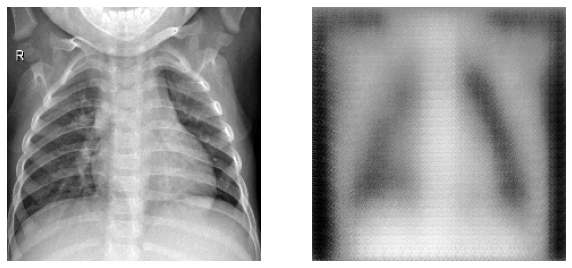

Time for epoch 1 is 65.94497394561768 sec


In [40]:
train(train_dataset, EPOCHS)

(-0.5, 223.5, 223.5, -0.5)

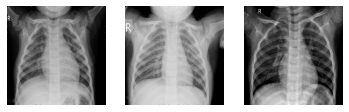

In [43]:
#fig = plt.figure(figsize=(18,6)) # commenting this out makes the images smaller
plt.subplot(1, 3, 1)
plt.imshow(valid_data[1, :, :, 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(valid_data[2, :, :, 1], cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(valid_data[3, :, :, 0], cmap='gray')
plt.axis('off')